## Author: Akash

Data Source: ACS 5 Year Survey 2018 (US Census Bureau), Homeland Infrastructure Foundation-Level Data (Hospitals)

In [ ]:
#Loading needed libraries
import datetime as dt
import time
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import fiona
from shapely.geometry import shape, mapping
import rtree
import fiona.crs
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import os
import contextily as ctx
import splot
import pysal
from libpysal import weights
import esda
from esda.moran import Moran, Moran_Local,Moran_BV, Moran_Local_BV
from splot.esda import lisa_cluster, plot_moran_bv_simulation, plot_moran_bv, plot_local_autocorrelation, moran_scatterplot

In [ ]:
!pip install arcgis==1.8.4

     |████████████████████████████████| 2.7 MB 27.8 MB/s 
     |████████████████████████████████| 567 kB 55.6 MB/s 
     |████████████████████████████████| 8.3 MB 72.3 MB/s 
     |████████████████████████████████| 219 kB 64.4 MB/s 
     |████████████████████████████████| 54 kB 65.6 MB/s 
     |████████████████████████████████| 45 kB 69.5 MB/s 
     |████████████████████████████████| 241 kB 96.9 MB/s 
     |████████████████████████████████| 45 kB 64.6 MB/s 
     |████████████████████████████████| 65 kB 80.0 MB/s 
  Created wheel for arcgis: filename=arcgis-1.8.4-py2.py3-none-any.whl size=3495922 sha256=e14508fba069c26b13e8be196971e61ff6940a19b0b1560da83c2844a39821db
  Stored in directory: /tmp/pip-ephem-wheel-cache-gwzk9f_5/wheels/4e/df/aa/6f157832f98f19d0d8d30e554d5979efafa7b150909bdd3f09
  Created wheel for lerc: filename=lerc-0.1.0-py3-none-any.whl size=571698 sha256=676484320dabd45aa568add4702c5bb3721b0c3813d0cfb7646117c5625571e1
  Stored in directory: /tmp/pip-ephem-wheel-cache-gwz

In [ ]:
#ArcGIS libraries
from arcgis.gis import GIS
import arcgis.network as network
from arcgis.features import FeatureLayer, Feature, FeatureSet, use_proximity

In [ ]:
#Loading hospitals data
hospital_infra = gpd.read_file('/work/COVIDRedlining/data/hospital infrastructure/Hospitals.shp')
hospital_infra.head()

,OBJECTID,ID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,TELEPHONE,TYPE,...,WEBSITE,STATE_ID,ALT_NAME,ST_FIPS,OWNER,TTL_STAFF,BEDS,TRAUMA,HELIPAD,geometry
0,1,0005793230,CENTRAL VALLEY GENERAL HOSPITAL,1025 NORTH DOUTY STREET,HANFORD,CA,93230,NOT AVAILABLE,NOT AVAILABLE,GENERAL ACUTE CARE,...,http://www.hanfordhealth.com,NOT AVAILABLE,NOT AVAILABLE,06,PROPRIETARY,-999,49.0,NOT AVAILABLE,N,POINT (-13318894.759 4346975.444)
1,2,0053391362,LOS ROBLES HOSPITAL & MEDICAL CENTER - EAST CA...,150 VIA MERIDA,WESTLAKE VILAGE,CA,91362,NOT AVAILABLE,NOT AVAILABLE,GENERAL ACUTE CARE,...,http://www.losrobleshospital.com,NOT AVAILABLE,NOT AVAILABLE,06,PROPRIETARY,-999,62.0,NOT AVAILABLE,N,POINT (-13226507.273 4049625.553)
2,3,0011190023,EAST LOS ANGELES DOCTORS HOSPITAL,4060 WHITTIER BOULEVARD,LOS ANGELES,CA,90023,NOT AVAILABLE,NOT AVAILABLE,GENERAL ACUTE CARE,...,http://www.elalax.com,NOT AVAILABLE,NOT AVAILABLE,06,PROPRIETARY,-999,127.0,NOT AVAILABLE,N,POINT (-13156201.046 4031977.723)
3,4,0017090028,SOUTHERN CALIFORNIA HOSPITAL AT HOLLYWOOD,6245 DE LONGPRE AVENUE,HOLLYWOOD,CA,90028,NOT AVAILABLE,(323) 462-2271,GENERAL ACUTE CARE,...,http://sch-hollywood.com/,NOT AVAILABLE,HOLLYWOOD COMMUNITY HOSPITAL OF HOLLYWOOD,06,PROPRIETARY,-999,100.0,NOT AVAILABLE,N,POINT (-13171904.894 4041752.386)
4,5,0023691706,KINDRED HOSPITAL BALDWIN PARK,14148 FRANCISQUITO AVENUE,BALDWIN PARK,CA,91706,NOT AVAILABLE,NOT AVAILABLE,GENERAL ACUTE CARE,...,http://www.khbaldwinpark.com,NOT AVAILABLE,NOT AVAILABLE,06,PROPRIETARY,-999,95.0,NOT AVAILABLE,N,POINT (-13132075.105 4037269.759)


In [ ]:
#Shape and Size of hospital_infra dataset

hospital_infra.shape

(7596, 33)

<b>Dataset Description</b>

[hospital_infra] has around 7596 hospital values across United States and contains information on hospital type, status (open vs closed), ownership status, number of beds, treatment specialty. The breakdown is as follows - 

Hospital Type :

GENERAL ACUTE CARE    4481,
CRITICAL ACCESS       1027,
PSYCHIATRIC            759,
LONG TERM CARE         431,
REHABILITATION         378,
MILITARY               216,
SPECIAL                145,
CHILDREN               130,
WOMEN                   20,
CHRONIC DISEASE          9

Status: 
OPEN      7277,
CLOSED     319


Ownership Status : 

NON-PROFIT                         3515,
PROPRIETARY                        2076,
GOVERNMENT - DISTRICT/AUTHORITY     517,
GOVERNMENT - LOCAL                  502,
NOT AVAILABLE                       428,
GOVERNMENT - STATE                  290,
GOVERNMENT - FEDERAL                266,
LIMITED LIABILITY COMPANY             2

Treatment Specialty (TRAUMA) :

NOT AVAILABLE                                     5472,
LEVEL IV                                           876,
LEVEL III                                          481,
LEVEL II                                           320,
LEVEL I                                            202,
TRH                                                 38,
TRF                                                 33,
LEVEL I, LEVEL II PEDIATRIC                         30,
CTH                                                 26,
LEVEL I PEDIATRIC                                   25,
LEVEL I, LEVEL I PEDIATRIC                          18,
LEVEL V                                             17,
LEVEL II, LEVEL II PEDIATRIC                        13

The dataset also has latitude, longitude pairs and NAICS codes that can be used for spatial indexing

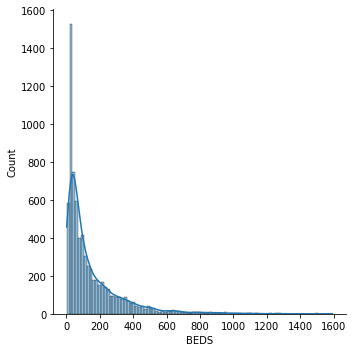

In [ ]:
#Distribution of beds across hospitals 

ax = sns.displot(hospital_infra[hospital_infra['BEDS'] > 0]['BEDS'], kde = True)

The MAPC documentation on Food Access Index outlines creation of relative weights for ability to procure quality food options across the full diet. A similar approach can be applied to the hospitals infra data based on the number of beds, ownership status etc. But for this iteration, dropping the creation of weights based on the following assumptions - 1. allocation of patients during the Covid-19 pandemic to wherever beds are available and 2. individuals wanting to seek care are able to do so at their nearest facility

In [ ]:
#Number of hospitals in Boston
hospital_infra[hospital_infra['CITY']=='BOSTON'].shape

(22, 33)

There are only 22 hospitals in all of Boston? 

<b>Creating Hospital Deserts based on Walkability and Drivability buffers</b>

To see which tracts lack access to hospitals, we will be generating 1 mile walkability and 4 miles drivability street network analysis across all tracts

In [ ]:
my_gis = GIS('https://www.arcgis.com', 'Akash_Yadav_LearnArcGIS9', 'covidredlining@123', verify_cert=False, set_active=True)

In [ ]:
#Creating a feature layer
hospital_fl = FeatureLayer()

In [ ]:
hospital_fl = FeatureLayer(hospital_infra)

In [ ]:
list_of_breaks = [5,10,15]
if isinstance(list_of_breaks, list):
    string_of_breaks = ' '.join(map(str, list_of_breaks))
    print(string_of_breaks)

5 10 15


In [ ]:
facilities = hospital_infra[hospital_infra['CITY']=='BOSTON']

In [ ]:
current_time = dt.datetime.now() 

result1 = network.analysis.generate_service_areas(facilities=facilities, break_values=string_of_breaks, 
                                                    break_units="Minutes", time_of_day=current_time)

Exception: User does not have permissions to access 'world/serviceareas.gpserver'.
(Error Code: 403)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c9a4f701-31a5-4164-b3f3-c09cddf1309e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>